In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [ ]:
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
epsilon_clip      = 0.1
KL_div      = 3
timestep     = 20

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/ipy

number of episodes :0, average score is: 0.16
number of episodes :100, average score is: 39.02
number of episodes :200, average score is: 199.23
number of episodes :300, average score is: 285.30
number of episodes :400, average score is: 311.29
number of episodes :500, average score is: 346.84
number of episodes :600, average score is: 154.16
number of episodes :700, average score is: 354.87
number of episodes :800, average score is: 319.43
number of episodes :900, average score is: 247.34
number of episodes :1000, average score is: 322.99
number of episodes :1100, average score is: 226.58
number of episodes :1200, average score is: 189.43
number of episodes :1300, average score is: 233.27
number of episodes :1400, average score is: 213.50
number of episodes :1500, average score is: 343.94
number of episodes :1600, average score is: 290.98
number of episodes :1700, average score is: 332.72
number of episodes :1800, average score is: 386.36
number of episodes :1900, average score is: 18

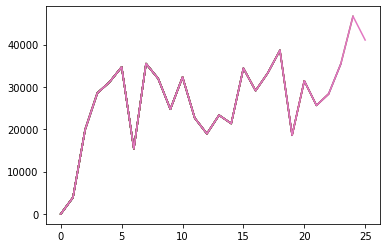

In [ ]:
class PPOpolicy(nn.Module):
    def __init__(self):
        super(PPOpolicy, self).__init__()
        self.memory = []
        
        self.fc1   = nn.Linear(4,256)
        self.fc2 = nn.Linear(256,2)
        self.fc_ppo  = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def actor(self, state, softmax_dim = 0):
        state = F.relu(self.fc1(state))
        state = self.fc2(state)
        prob = F.softmax(state, dim=softmax_dim)
        return prob
    
    def critic(self, state):
        state = F.relu(self.fc1(state))
        critic = self.fc_ppo(state)
        return critic
      
    def insert(self, mem):
        self.memory.append(mem)
        
    def make_batch(self):
        state_lst=[] 
        action_lst=[]  
        reward_lst=[] 
        state_prime_lst=[] 
        prob_action_lst=[] 
        done_lst = [] 
        for mem in self.memory:
            state, action, reward, state_prime, prob_action, done = mem
            
            state_lst.append(state)
            action_lst.append([action])
            reward_lst.append([reward])
            state_prime_lst.append(state_prime)
            prob_action_lst.append([prob_action])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        state,action,reward,state_prime,done_mask, prob_action = torch.tensor(state_lst, dtype=torch.float), torch.tensor(action_lst), \
                                          torch.tensor(reward_lst), torch.tensor(state_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_action_lst)
        self.memory = []
        return state,action,reward,state_prime,done_mask, prob_action
        
    def train(self):
        state,action,reward,state_prime,done_mask, prob_action = self.make_batch()
        for i in range(3):

            td_target = reward + gamma * self.critic(state_prime) * done_mask
            delta = td_target - self.critic(state)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.actor(state, softmax_dim=1)
            pi_a = pi.gather(1,action)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_action))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-epsilon_clip, 1+epsilon_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.critic(state) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

env = gym.make('CartPole-v1')
EPISODE=10000
total_reward_graph_for_avg=[]
def main():
    model = PPOpolicy()
    score = 0.0
    print_interval = 100
    breakpoint=470
    total_reward_graph=[]

    for ep in range(EPISODE):
        state = env.reset()
        #env.render()
        done = False
        while not done:
            for time in range(timestep):
                prob = model.actor(torch.from_numpy(state).float())
                mod = Categorical(prob)
                action = mod.sample().item()
                state_prime, reward, done, info = env.step(action)

                model.insert((state, action, reward/100.0, state_prime, prob[action].item(), done))
                state = state_prime

                score += reward
                if done:
                    break

            model.train()

        if ep%print_interval==0:
            print("number of episodes :{}, average score is: {:.2f}".format(ep, score/print_interval))
            score_to_plot=score/print_interval
            plt.plot(total_reward_graph)
            total_reward_graph.append(score)
            total_reward_graph_for_avg.append(score_to_plot)
            score = 0.0
        if score/print_interval>=470:
            print("Average score of 100 episodes is 470")
            
            plt.plot(total_reward_graph)
            break;

    env.close()

if __name__ == '__main__':
    main()

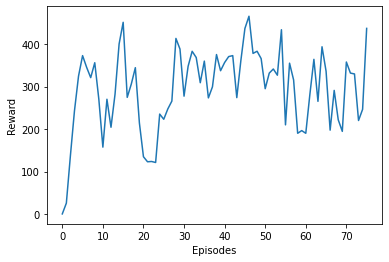

In [ ]:
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(total_reward_graph_for_avg)